# Document Parsing with Qwen3-VL (Together AI)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/togethercomputer/together-cookbook/blob/main/Multimodal/Vision/Document_Parsing.ipynb)


## Introduction

In this notebook, we'll explore Qwen3-VL's document parsing capabilities using Together AI's API. We'll convert documents to structured formats:

1. **QwenVL HTML**: HTML with `<bbox>` attributes for element coordinates
2. **QwenVL Markdown**: Markdown with LaTeX tables and image placeholders

These capabilities are useful for document digitization, data extraction, and building RAG systems.


### Install required libraries


In [ ]:
!pip install openai pillow beautifulsoup4 requests


In [1]:
import os
import re
import base64
import requests
import openai
from io import BytesIO
from PIL import Image, ImageDraw, ImageFont
from bs4 import BeautifulSoup, Tag
from IPython.display import display, Markdown

# Together AI Configuration
client = openai.OpenAI(
    api_key=os.environ.get("TOGETHER_API_KEY"),
    base_url="https://api.together.xyz/v1",
)

MODEL_ID = "Qwen/Qwen3-VL-32B-Instruct"

print(f"Using model: {MODEL_ID}")
print(f"API Key configured: {bool(os.environ.get('TOGETHER_API_KEY'))}")


Using model: Qwen/Qwen3-VL-32B-Instruct
API Key configured: True


In [2]:
# Utility functions

def encode_image(image_path):
    with open(image_path, "rb") as f:
        return base64.b64encode(f.read()).decode("utf-8")

def inference_with_api(image_path, prompt, max_tokens=8192):
    base64_image = encode_image(image_path)
    ext = image_path.split(".")[-1].lower()
    mime_type = "jpeg" if ext in ["jpg", "jpeg"] else ext
    
    response = client.chat.completions.create(
        model=MODEL_ID,
        messages=[{
            "role": "user",
            "content": [
                {"type": "image_url", "image_url": {"url": f"data:image/{mime_type};base64,{base64_image}"}},
                {"type": "text", "text": prompt},
            ],
        }],
        max_tokens=max_tokens,
    )
    return response.choices[0].message.content

def draw_bbox_html(image_path, full_predict):
    """Visualize QwenVL HTML data-bbox boxes."""
    if image_path.startswith("http"):
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(image_path).convert("RGB")
    
    width, height = image.size
    soup = BeautifulSoup(full_predict, 'html.parser')
    elements_with_bbox = soup.find_all(attrs={'data-bbox': True})

    filtered_elements = []
    for el in elements_with_bbox:
        if el.name == 'ol':
            continue
        elif el.name == 'li' and el.parent.name == 'ol':
            filtered_elements.append(el)
        else:
            filtered_elements.append(el)

    try:
        font = ImageFont.truetype("/usr/share/fonts/truetype/dejavu/DejaVuSans.ttf", 10)
    except:
        font = ImageFont.load_default()
    
    draw = ImageDraw.Draw(image)
    
    for element in filtered_elements:
        bbox_str = element['data-bbox']
        text = element.get_text(strip=True)[:30]  # Truncate long text
        try:
            x1, y1, x2, y2 = map(int, bbox_str.split())
        except:
            continue

        bx1 = int(x1 / 1000 * width)
        by1 = int(y1 / 1000 * height)
        bx2 = int(x2 / 1000 * width)
        by2 = int(y2 / 1000 * height)
        
        if bx1 > bx2: bx1, bx2 = bx2, bx1
        if by1 > by2: by1, by2 = by2, by1
            
        draw.rectangle([bx1, by1, bx2, by2], outline='red', width=2)
        draw.text((bx1, by2), text, fill='black', font=font)

    display(image)

def draw_bbox_markdown(image_path, md_content):
    """Visualize Markdown Image/Table coordinate boxes."""
    if image_path.startswith("http"):
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content)).convert("RGB")
    else:
        image = Image.open(image_path).convert("RGB")
    
    width, height = image.size
    pattern = r"<!-- (Image|Table) \(\s*(\d+)\s*,\s*(\d+)\s*,\s*(\d+)\s*,\s*(\d+)\s*\) -->"
    matches = re.findall(pattern, md_content)
    
    draw = ImageDraw.Draw(image)
    for item in matches:
        typ, x1, y1, x2, y2 = item
        x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
        bx1 = int(x1 / 1000 * width)
        by1 = int(y1 / 1000 * height)
        bx2 = int(x2 / 1000 * width)
        by2 = int(y2 / 1000 * height)
        
        if bx1 > bx2: bx1, bx2 = bx2, bx1
        if by1 > by2: by1, by2 = by2, by1
        
        color = 'blue' if typ == "Image" else 'red'
        draw.rectangle([bx1, by1, bx2, by2], outline=color, width=4)

    display(image)


## 1. Document Parsing in QwenVL HTML Format

Generate HTML with bounding boxes for each element.


HTML Output (first 2000 chars):
```html
<!DOCTYPE html>
<html lang="zh">
<head>
    <meta charset="UTF-8">
    <title>宇通客车 (600066) 7月销量转正，T7前景看好</title>
    <style>
        body {
            font-family: Arial, sans-serif;
            margin: 0;
            padding: 0;
            background-color: #fff;
            color: #000;
        }
        .container {
            width: 100%;
            max-width: 1200px;
            margin: 0 auto;
            padding: 20px;
        }
        .header {
            display: flex;
            justify-content: space-between;
            align-items: center;
            margin-bottom: 20px;
            border-bottom: 2px solid #000;
            padding-bottom: 10px;
        }
        .logo {
            display: flex;
            align-items: center;
        }
        .logo img {
            height: 60px;
        }
        .date {
            font-size: 18px;
            font-weight: bold;
        }
        .title {
            font-size: 28px;

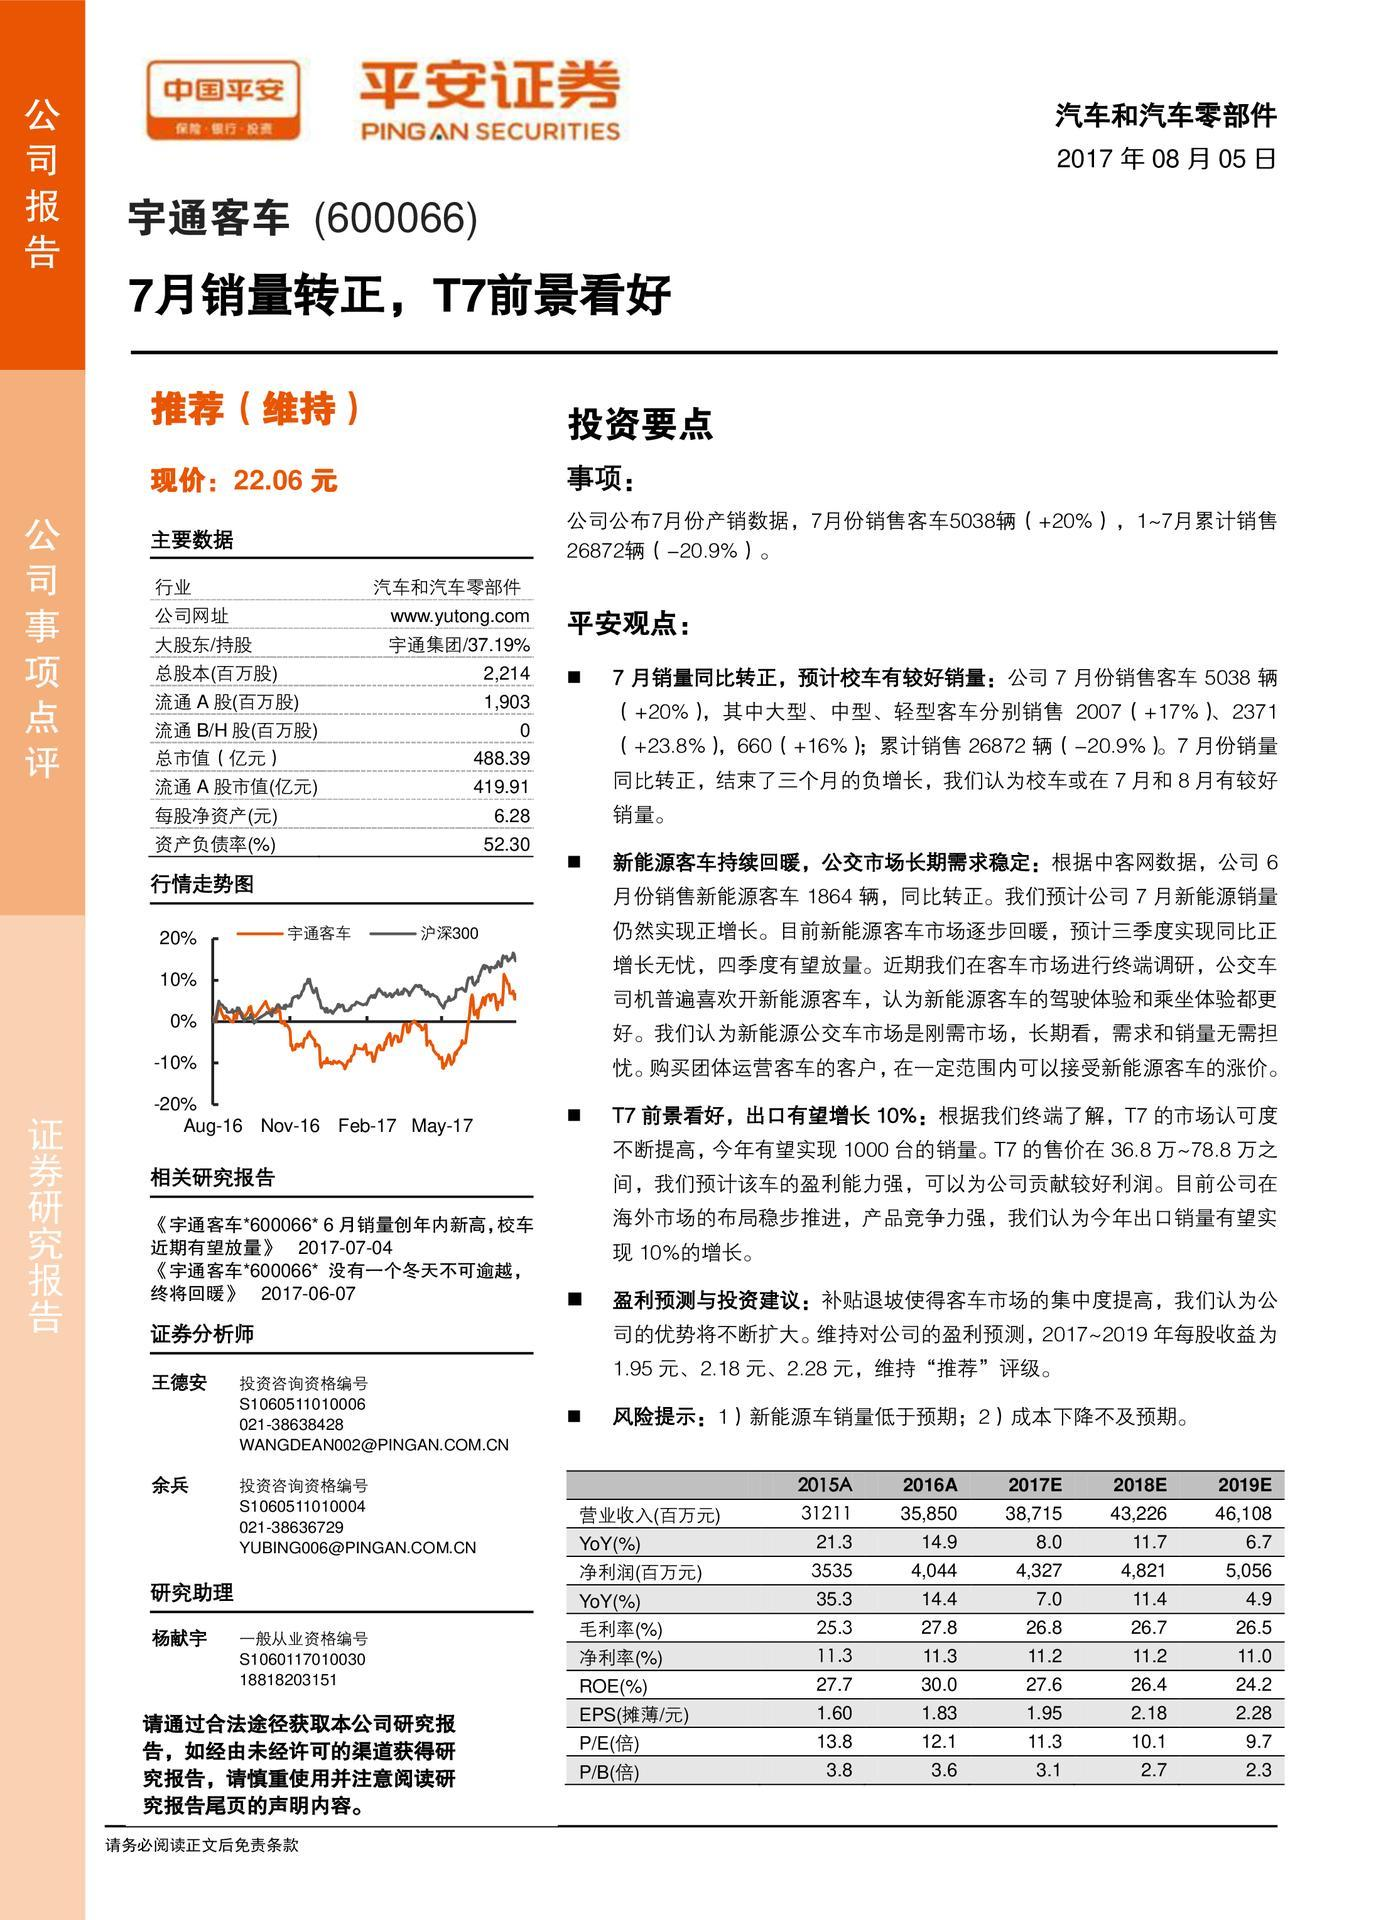

In [3]:
# Download and save sample image
img_url = "https://ofasys-multimodal-wlcb-3-toshanghai.oss-cn-shanghai.aliyuncs.com/Qwen3VL/demo/omni_parsing/179729.jpg"
img_name = "sample_doc_html.jpg"

response = requests.get(img_url)
image = Image.open(BytesIO(response.content))
image.save(img_name)

prompt = "qwenvl html"

output = inference_with_api(img_name, prompt)
print("HTML Output (first 2000 chars):")
print(output[:2000])

draw_bbox_html(img_name, output)


## 2. Document Parsing in QwenVL Markdown Format

Generate Markdown with tables in LaTeX and coordinate placeholders for images.


In [ ]:
# Download and save sample image
img_url = "https://ofasys-multimodal-wlcb-3-toshanghai.oss-cn-shanghai.aliyuncs.com/Qwen3VL/demo/omni_parsing/120922.jpg"
img_name = "sample_doc_md.jpg"

response = requests.get(img_url)
image = Image.open(BytesIO(response.content))
image.save(img_name)

prompt = "qwenvl markdown"

output = inference_with_api(img_name, prompt)
print("Markdown Output (first 2000 chars):")
print(output[:2000])

draw_bbox_markdown(img_name, output)
